# Unsupervised Learning: Allocating Funding to Countries in Need

## Problem Description

According to the International Monetary Fund (IMF), development aid is aid given by governments and other agencies to support the economic, environmental, social, and political development of developing countries. HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during time of disasters and natural calamities. HELP International has been able to raise around $ 10 million. To use this money strategically and effectively, the CEO has to make a decision to focus on the countries that are in the direst need of aid.  

## Motivation & Goal

The goal of this project is to use unsupervised learning to categorize the countries based on some socioeconomic and health factors that determine the overall development of the country. Then we need to suggest the countries which the CEO needs to focus on the most.

## Dataset

The dataset and its data dictionary are available on [Kaggle](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data). 

## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering as agc
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as sch
import plotly.express as px

## Reading Data

In [2]:
# to avoid any potential problems, I downloaded the files and read them locally
data_df = pd.read_csv('Country-data.csv')
data_dict = pd.read_csv('data-dictionary.csv')

## Exploratory Data Analysis

Let's take a quick look at the dataset.

In [3]:
data_df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [4]:
data_df.describe()

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

### Data Cleaning

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We can see that `country` is an object variable, other features are either float or integer. The name of the country is not an important feature for unsupervised learning in this project, so we could drop the `country` column. 

In [6]:
data = data_df.drop('country', axis = 1)
data.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  
0       5.82    553  
1       1.65   4090  
2       2.89   4460  
3       6.16   3530  
4       2.13  12200

Based on the dataset description above, there is no null value. Let's confirm that and also check if there is any duplicate. 

In [7]:
data.isna().sum() # no null value

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [8]:
data.duplicated().any() # no duplicate

False

### Features in the dataset

In [9]:
# read the dataset dictionary 
data_dict

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

Let's check the data distribution in each featrue.

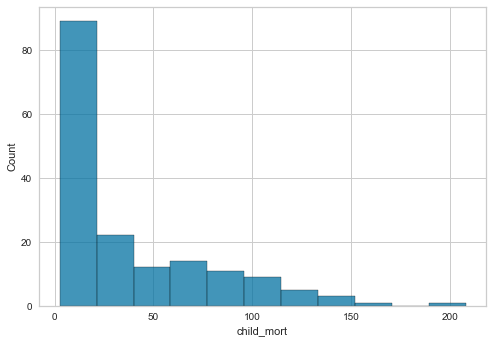

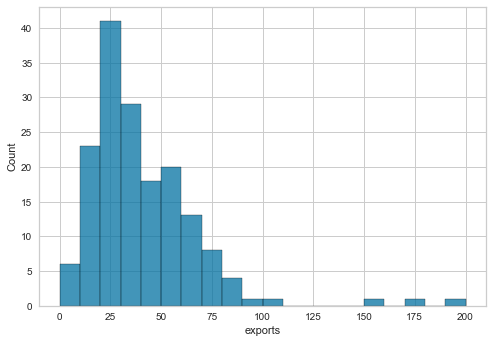

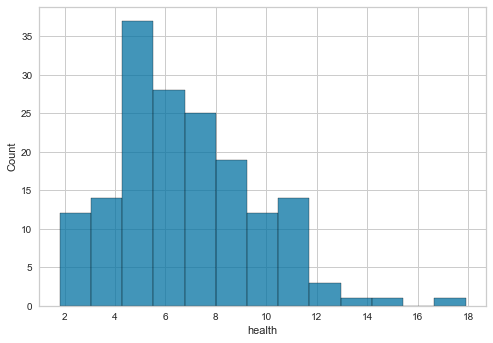

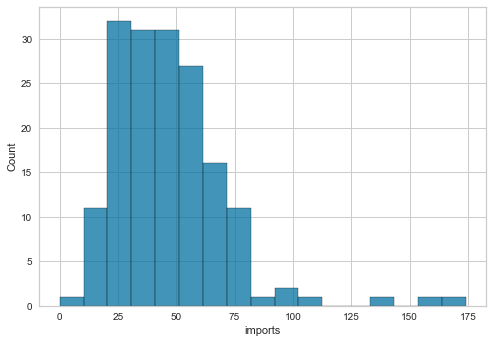

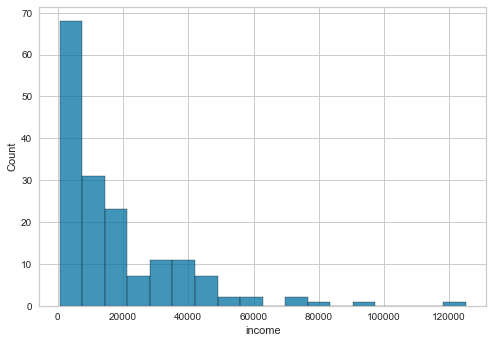

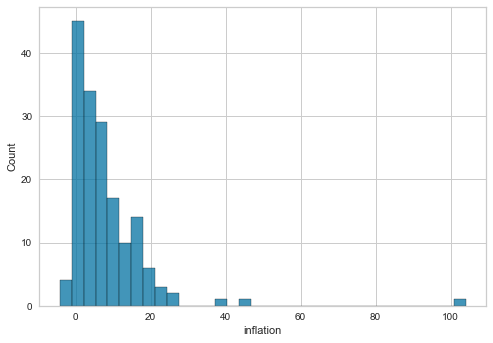

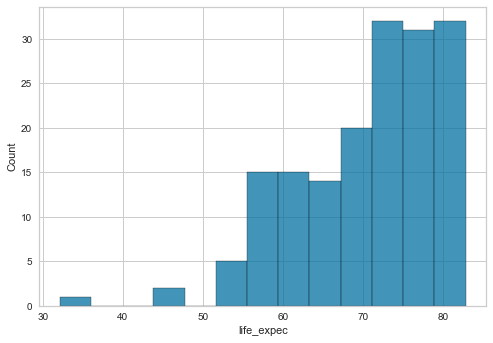

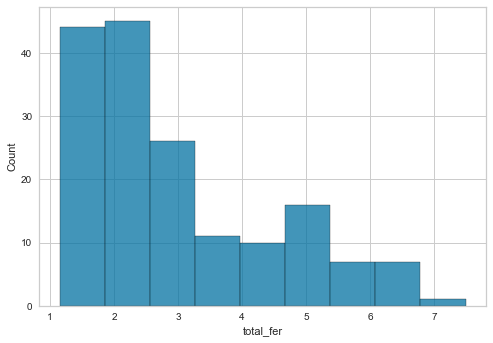

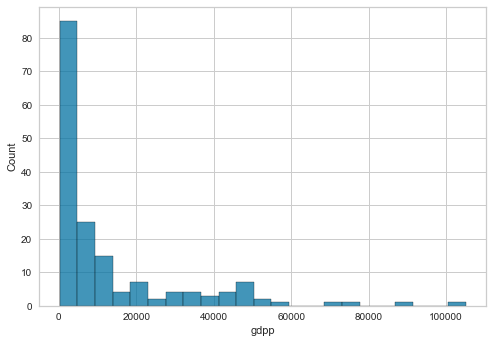

In [10]:
for feature in list(data.columns):
    sns.histplot(data = data, x=str(feature))
    plt.show()

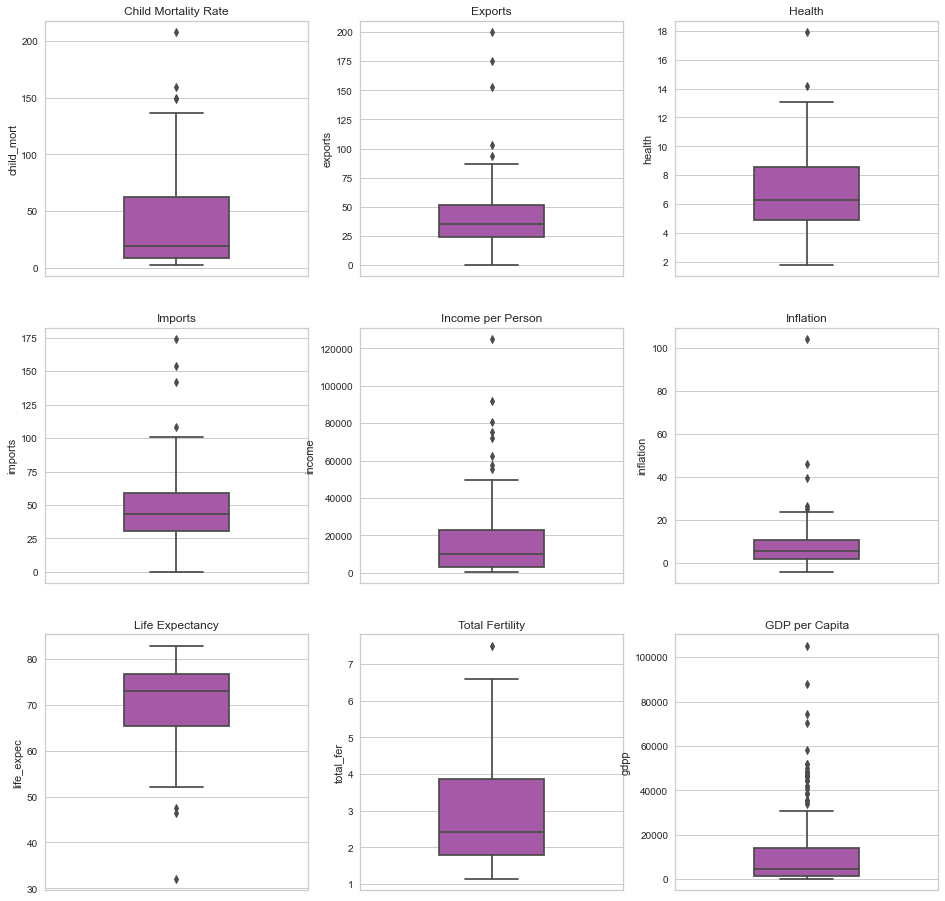

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
sns.boxplot(y=data.child_mort,ax=ax[0, 0], width=0.4, color='magenta', saturation=0.3)
ax[0, 0].set_title('Child Mortality Rate')
sns.boxplot(y=data.exports,ax=ax[0, 1], width=0.4, color='magenta', saturation=0.3)
ax[0, 1].set_title('Exports')
sns.boxplot(y=data.health,ax=ax[0, 2], width=0.4, color='magenta', saturation=0.3)
ax[0,2].set_title('Health')
sns.boxplot(y=data.imports,ax=ax[1, 0], width=0.4, color='magenta', saturation=0.3)
ax[1,0].set_title('Imports')
sns.boxplot(y=data.income,ax=ax[1,1], width=0.4, color='magenta', saturation=0.3)
ax[1, 1].set_title('Income per Person')
sns.boxplot(y=data.inflation,ax=ax[1, 2], width=0.4, color='magenta', saturation=0.3)
ax[1,2].set_title('Inflation')
sns.boxplot(y=data.life_expec,ax=ax[2,0], width=0.4, color='magenta', saturation=0.3)
ax[2,0].set_title('Life Expectancy')
sns.boxplot(y=data.total_fer, ax=ax[2, 1], width=0.4, color='magenta', saturation=0.3)
ax[2,1].set_title('Total Fertility')
sns.boxplot(y=data.gdpp,ax=ax[2,2], width=0.4, color='magenta', saturation=0.3)
ax[2,2].set_title('GDP per Capita')
plt.show()

### Pairwise feature correlation

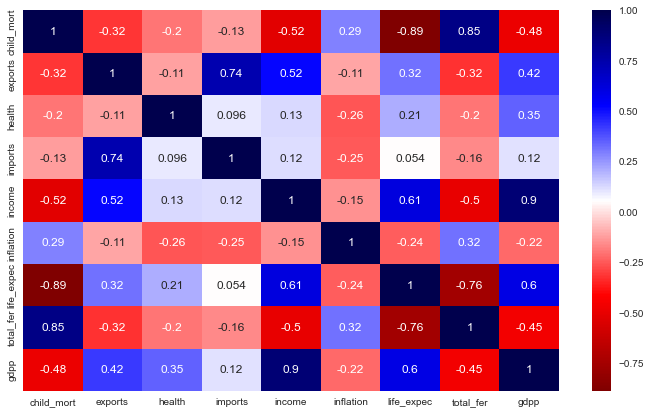

In [12]:
plt.figure(figsize = (12,7))
sns.heatmap(data.corr(), annot = True, cmap="seismic_r")
plt.show()

We can see that gdpp and income, child_mort and total_fert, imports and exports, are highly positive correlated,
whereas life_expec and child_mort are highly negative correlated.

### Standardization

We can see from the box plots that there is a considerable difference in the range of the data. Some features such as income and gdpp, have much bigger values, which will dominate over other features. So we will transform the data to a uniform scale to create consistency across the fields in the DataFrame.

In [13]:
# transform the data so that the mean will be 0 and variance will be 1
sc=StandardScaler()
data_scaled=sc.fit_transform(data)

In [14]:
data_scaled

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

<AxesSubplot:>

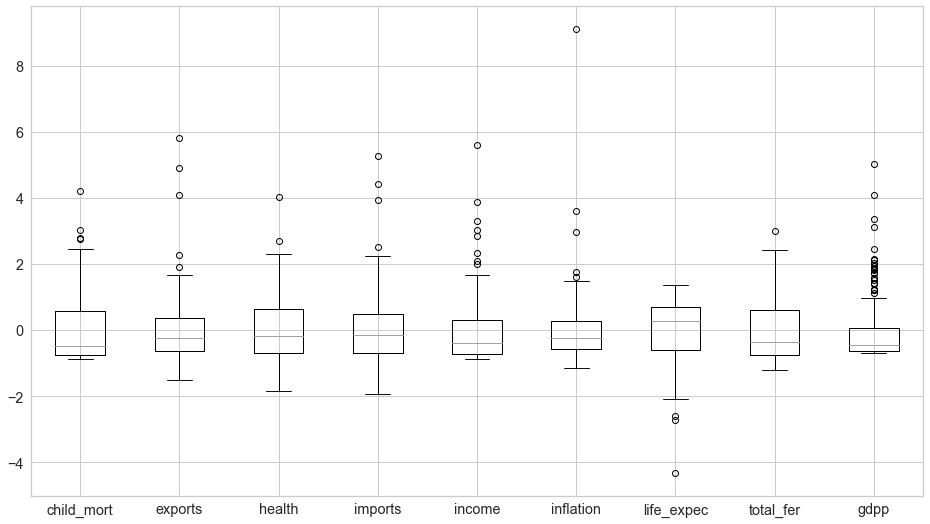

In [15]:
data_stan = pd.DataFrame(data_scaled, columns = data.columns)
data_stan.boxplot(fontsize = 'large', figsize = (16, 9))

From the box plots above we can see many `outliers` in the dataset. We are not going to remove the `outliers` from the dataset, because 1) they may provide genuine insights about the countries; 2) the dataset is relatively small (only 167 rows) and we want to keep more data.

### Principal Component Analysis (PCA)

Here PCA is used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while keeping as much of the data's variation as possible. 

In [16]:
pc = PCA() 
data_pca = pd.DataFrame(pc.fit_transform(data_scaled))

# n_components is min(n_samples, n_features), so it is equal to n_features
print(f"Total number of principal components is {pc.n_components_}.")

Total number of principal components is 9.


In [17]:
# principal axes in feature space, representing the directions of maximum variance in the data
# ndarray of shape (n_features, n_features), i.e., (9,9)
pc.components_

array([[-0.41951945,  0.28389698,  0.15083782,  0.16148244,  0.39844111,
        -0.19317293,  0.42583938, -0.40372896,  0.39264482],
       [ 0.19288394,  0.61316349, -0.24308678,  0.67182064,  0.02253553,
        -0.00840447, -0.22270674,  0.15523311, -0.0460224 ],
       [-0.02954353,  0.14476069, -0.59663237, -0.29992674,  0.3015475 ,
         0.64251951,  0.11391854,  0.01954925,  0.12297749],
       [ 0.37065326,  0.00309102,  0.4618975 , -0.07190746,  0.39215904,
         0.15044176, -0.20379723,  0.37830365,  0.53199457],
       [-0.16896968,  0.05761584,  0.51800037,  0.25537642, -0.2471496 ,
         0.7148691 ,  0.1082198 , -0.13526221, -0.18016662],
       [ 0.20062815, -0.05933283,  0.00727646, -0.03003154,  0.16034699,
         0.06628537, -0.60112652, -0.75068875,  0.01677876],
       [-0.07948854, -0.70730269, -0.24983051,  0.59218953,  0.09556237,
         0.10463252,  0.01848639,  0.02882643,  0.24299776],
       [-0.68274306, -0.01419742,  0.07249683, -0.02894642,  0

In [18]:
# percentage of variance explained by each component
pc.explained_variance_ratio_

array([0.4595174 , 0.17181626, 0.13004259, 0.11053162, 0.07340211,
       0.02484235, 0.0126043 , 0.00981282, 0.00743056])

In [19]:
# calculate the cumulative explained variance ratio
exp_ratio_sum = np.cumsum(pc.explained_variance_ratio_)
exp_ratio_sum

array([0.4595174 , 0.63133365, 0.76137624, 0.87190786, 0.94530998,
       0.97015232, 0.98275663, 0.99256944, 1.        ])

Now let's visualize the cumulative explained variance. 

<AxesSubplot:title={'center':'PCs vs. Cumulative explained variance ratio'}, xlabel='Number of principle components', ylabel='Cumulative explained variance ratio'>

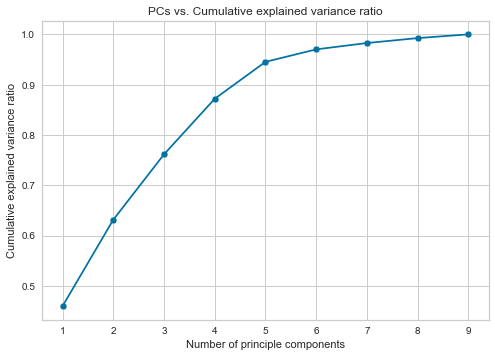

In [20]:
sns.lineplot(x = np.arange(1,10), y= exp_ratio_sum).set(xlabel='Number of principle components', 
                                                       ylabel='Cumulative explained variance ratio', 
                                                       title='PCs vs. Cumulative explained variance ratio')
sns.scatterplot(x = np.arange(1,10), y= exp_ratio_sum)


Based the PCA above, we can see that the first 4 components can explain about 90% of the variation of the original data, so I will use them moving forward. 

In [21]:
data_pca.drop(columns = [4, 5, 6, 7, 8], inplace = True)
data_pca.head()

0         1         2         3
0 -2.913025  0.095621 -0.718118  1.005255
1  0.429911 -0.588156 -0.333486 -1.161059
2 -0.285225 -0.455174  1.221505 -0.868115
3 -2.932423  1.695555  1.525044  0.839625
4  1.033576  0.136659 -0.225721 -0.847063

## Unsupervised Learning Models

### Model: K-Means Clustering

K-means clustering is an iterative algorithm that divides the data into k clusters/subgroups based on the similarity measured by their mean distance from the centroid of certain subgroups. `n_clusters` is the most commonly adjusted K-Means `parameter`. In order to tune this parameter to get the optimal `n_clusters`, here we will try multiple methods: **elbow method, Silhouette score, and Davies Bouldin score**. 

### Finding the optimal n_clusters by elbow method

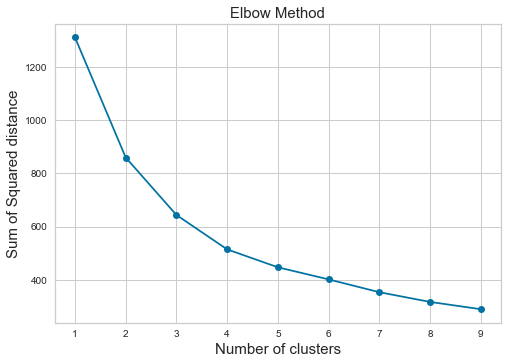

In [22]:
a=[]
K=range(1,10)
for k in K:
    kmean=KMeans(n_clusters=k)
    kmean.fit(data_pca)
    a.append(kmean.inertia_)
    
plt.plot(K,a,marker='o')
plt.title('Elbow Method',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Sum of Squared distance',fontsize=15)
plt.show()

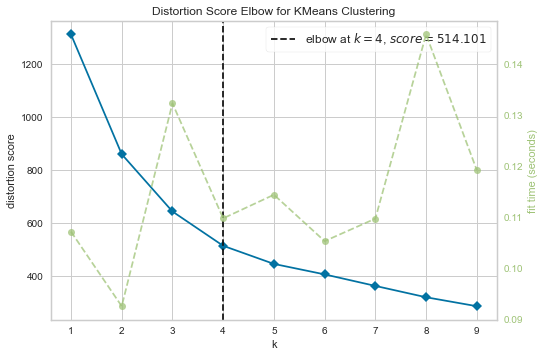

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
visualizer = KElbowVisualizer(kmean, k=(1,10))
visualizer.fit(data_pca)
visualizer.poof()

We can see that the elbo bends at 4, which suggests we should choose 4 as the number of clusters. 

### Finding the optimal n_clusters by Silhouette score

The `Silhouette score` is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from −1 to +1, where a high value indicates better clustering. 

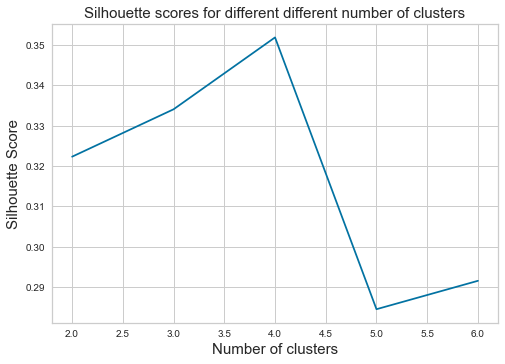

In [24]:
silhouetee_scores = []
K=range(2,7)
for k in K:
    kmean=KMeans(n_clusters=k)
    kmean.fit(data_pca)
    cluster_labels =  kmean.labels_
    
    # calculate silhouette score
    silhouetee_score = silhouette_score(data_pca, cluster_labels)
    silhouetee_scores.append(silhouetee_score)
plt.plot(K, silhouetee_scores)
plt.title('Silhouette scores for different different number of clusters',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Silhouette Score',fontsize=15)
plt.show()

It seems that 4 is the optimal number of clusters. 

### Finding the optimal n_clusters by Davies Bouldin score

The Davies Bouldin score is calculated as the average similarity of each cluster with a cluster most similar to it. A lower Davies Bouldin score means better clustering. 

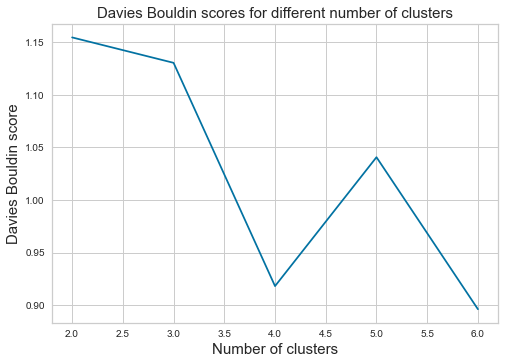

In [25]:
Davies_Bouldin_scores = []
K=range(2,7)
for k in K:
    kmean=KMeans(n_clusters=k)
    kmean.fit(data_pca)
    cluster_labels = kmean.labels_
    
    # calculate silhouette score
    Davies_Bouldin_score = davies_bouldin_score(data_pca, cluster_labels)
    Davies_Bouldin_scores.append(Davies_Bouldin_score)
plt.plot(K, Davies_Bouldin_scores)
plt.title('Davies Bouldin scores for different number of clusters',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Davies Bouldin score',fontsize=15)
plt.show()

Multiple methods suggest that 4 is the optimal number of clusters, so we will set n_clusters as 4 for the K-means model. 

In [26]:
kmeans = KMeans(n_clusters = 4,random_state = 2022)
kmeans.fit(data_pca)

KMeans(n_clusters=4, random_state=2022)

In [27]:
cluster_labels = kmeans.fit_predict(data_pca)

In [28]:
preds = kmeans.labels_
kmeans_df = pd.DataFrame(data_df)
kmeans_df['KMeans_Clusters'] = preds
kmeans_df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  KMeans_Clusters  
0       9.44        56.2       5.82    553                2  
1       4.49        76.3       1.65   4090                0  
2      16.10        76.5       2.89   4460                0  
3      22.40        60.1       6.16   3530                2  
4       1.44        76.8       2.13  12200                0

Let's plot a pair-plot to visualize the clusters based on K-means clustering. 

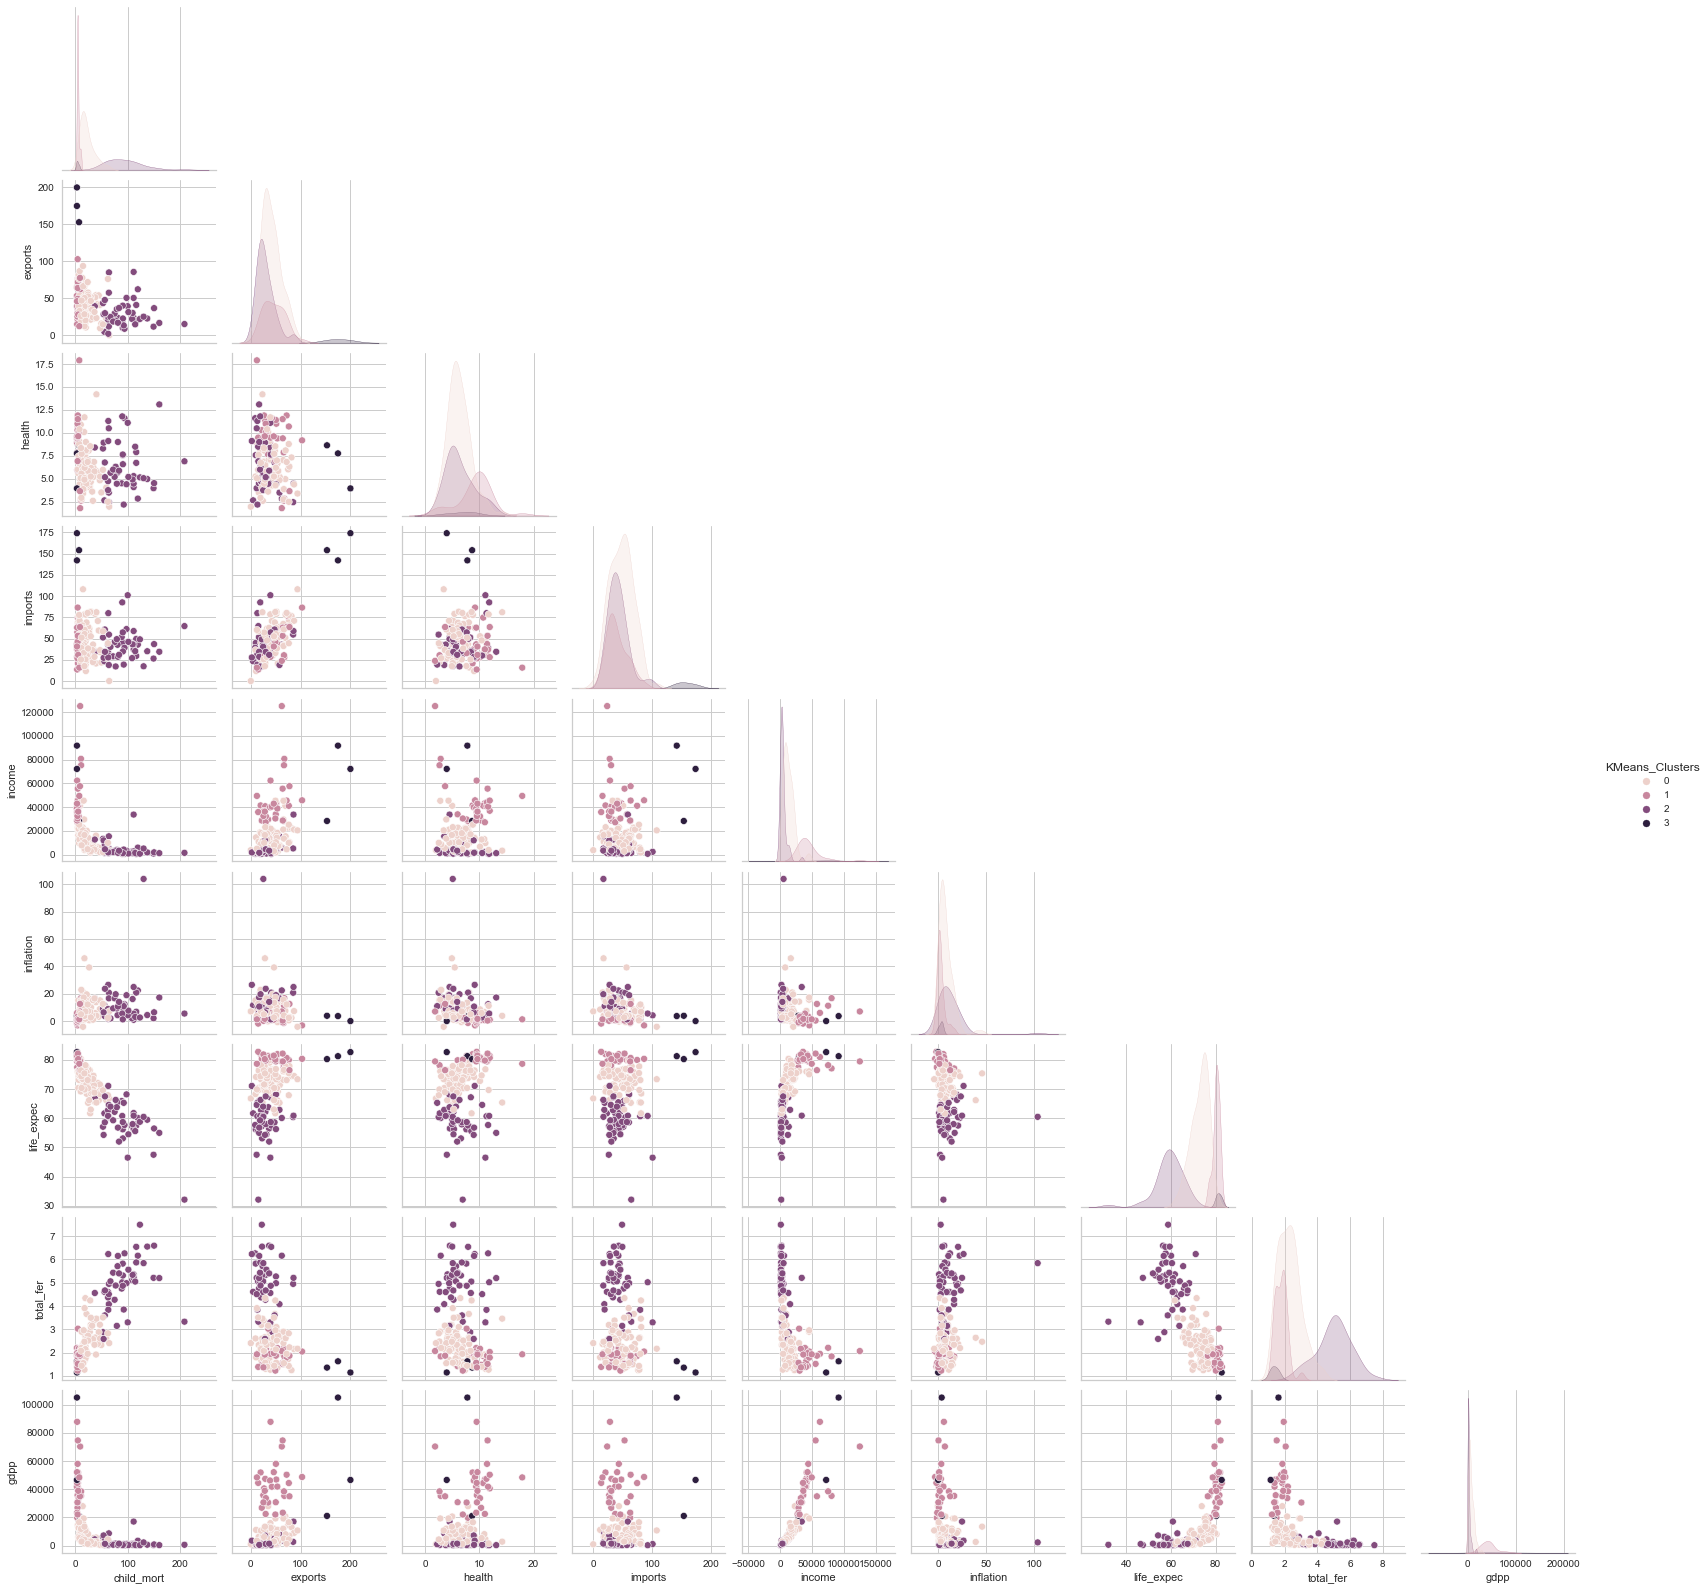

In [29]:
pair_plot = sns.pairplot(data = kmeans_df, hue = 'KMeans_Clusters', corner = True)

Let's calculate the number of countries in each category. 

In [30]:
kmeans_df.groupby(['KMeans_Clusters'])["KMeans_Clusters"].count()

KMeans_Clusters
0    86
1    31
2    47
3     3
Name: KMeans_Clusters, dtype: int64

From the pari plot above, we can see that some features are more import than others to cluster countries, such as `total_fer`, `child_mort`, `gdpp`, `life_expec`. In the pair plot blow, we'll focus only these featrues. 

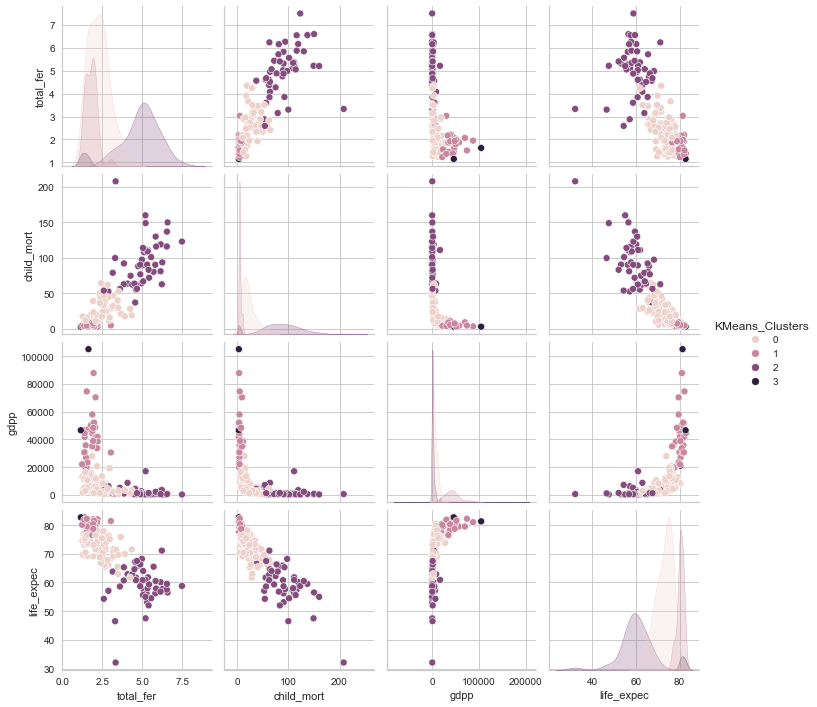

In [31]:
pair_plot = sns.pairplot(data = kmeans_df[["total_fer", "child_mort", "gdpp", "life_expec", 'KMeans_Clusters']], 
                         hue = 'KMeans_Clusters')

Compared with other categories, `Category 2` has the highest total fertility rate and child mortality rate, and is at the bottom in terms of the GDP per capita and life expectancy. Therefore, the countries in Category 2 need aid the most. 

Next let's try another clustering algorthim. 

### Model: Hierarchical Clustering

Hierarchical clustering is also an unsupervised learning algorithm used for cluster analysis. This algorithm seeks to build a hierarchy of clusters. There are two types of hierarchical clustering, **Divisive Hierarchical Clustering** and **Agglomerative Hierarchical Clustering**. 

#### Divisive Hierarchical Clustering

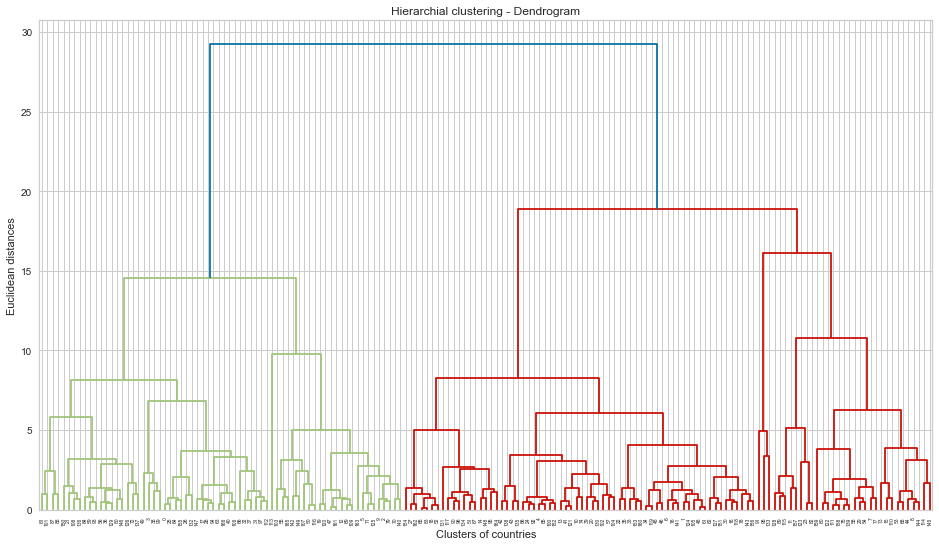

In [32]:
fig=plt.figure(figsize=(16,9))
dendrogram = sch.dendrogram(sch.linkage(data_pca, method = 'ward'))
plt.title('Hierarchial clustering - Dendrogram')
plt.xlabel('Clusters of countries')
plt.ylabel('Euclidean distances')
plt.show()

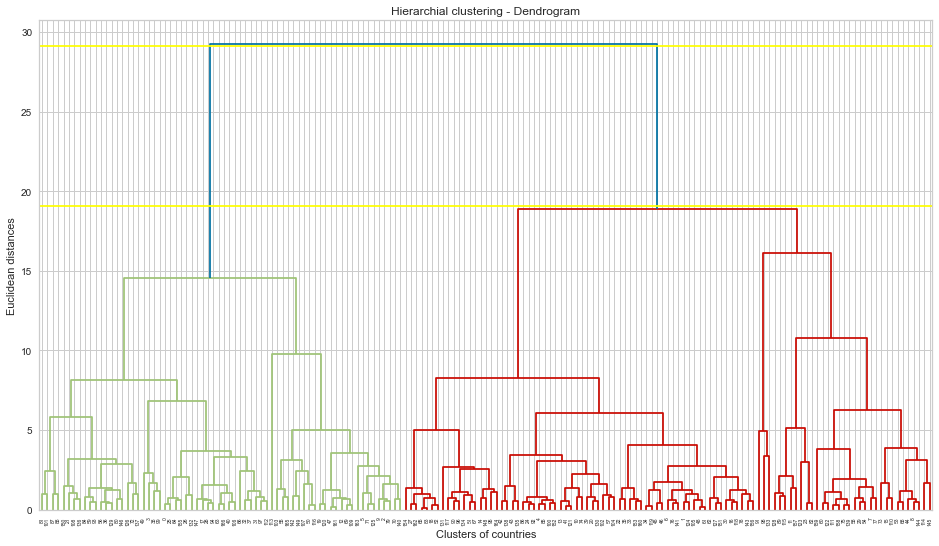

In [33]:
fig=plt.figure(figsize=(16,9))
dendrogram = sch.dendrogram(sch.linkage(data_pca, method = 'ward'))
plt.title('Hierarchial clustering - Dendrogram')
plt.xlabel('Clusters of countries')
plt.ylabel('Euclidean distances')
plt.axhline(y = 29.1, color = 'yellow', linestyle = '-')
plt.axhline(y = 19.1, color = 'yellow', linestyle = '-')
plt.show()

We can use the dendrogram method to determine the number of ideal clusters. The two horizontal lines (in yellow)determine the largest vertical distance that doesn't interact with any of the other clusters. The optimal number of clusters is equal to the number of vertical lines between the two horizontal lines. The countries are divided into two subgroups. 

#### Agglomerative Hierarchical Clustering

In [34]:
agc = agc(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
agc.fit(data_pca)
cluster_agc = pd.Series(agc.labels_)
print(pd.concat({'count' : cluster_agc.value_counts(), 
                 'percent' : round(cluster_agc.value_counts(normalize = True)*100, 2)}, 
                axis = 1 )) # calculate the number of countries in each group

   count  percent
0     99    59.28
1     68    40.72


### Choosing the better clustering model by Silhouette Score (higher is better)

In [35]:
cluster_KM = kmeans_df['KMeans_Clusters']
print(f"Silhouette Score for K-means clustering: {silhouette_score(data_pca, cluster_KM).round(3)}.")
print(f"Silhouette Score for Hierarchical clustering: {silhouette_score(data_pca, cluster_agc).round(3)}.")


Silhouette Score for K-means clustering: 0.349.
Silhouette Score for Hierarchical clustering: 0.307.


### Choosing the better clustering model by Davies Bouldin Score (lower is better)

In [36]:
print(f"Davies Bouldin Score for K-means clustering: {davies_bouldin_score(data_pca, cluster_KM).round(3)}.")
print(f"Davies Bouldin Score for Hierarchical clustering: {davies_bouldin_score(data_pca, cluster_agc).round(3)}.")


Davies Bouldin Score for K-means clustering: 0.917.
Davies Bouldin Score for Hierarchical clustering: 1.211.


Based on both Silhouette Score and Davies Bouldin Score, for the current dataset, K-means clustering is better than Hierarchical clustering. **So we will use K-means algorithm to deliver the result.**

## Conclusions & Discussion

1. According to our K-means clustering model, countries in Category 2 need the aid most. To use the money strategically and effectively, the CEO of HELP should focus on these countries first. 

In [37]:
cat2_countries = kmeans_df[kmeans_df.KMeans_Clusters==2].country
print(f"There are {cat2_countries.count()} countries that need the aid most.\n")
print(cat2_countries)

There are 47 countries that need the aid most.

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                      

2. As shown on the map below, most countries in African and a few countries in Asian such as Pakistan, Afganistan, Iraq, Yemen, and Lao (in orange color) will benefit the most with the aid. 

In [38]:
px.choropleth(data_frame = data_df, locationmode = 'country names', locations = 'country', 
              color = data_df['KMeans_Clusters'], title = 'Country Clustering using Unsupervised Learning (K-means)',
              color_discrete_map = {0:'#DB1C18', 1:'#EBB331',
                                  2:'#51A2DB', 3:'#67E232'} ,
              projection = 'equirectangular')

3. The clustering result alone is not sufficient to provide a final recommendation. A better model may require more features associated with a country's socioeconomic status. Additionally, further analysis may be needed on each country in order to find the best way to help. 

## Reference

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

https://www.kaggle.com/code/dikshabhati2002/k-means-and-hierarchical-clustering

https://www.kaggle.com/code/kasturikolambkar/cluster-countries-pca-kmeans-hierarchical-dbscan

## Github Repository
https://github.com/Benjamin2009/Unsupervised-Learning-Allocating-Funding-to-Countries-in-Need